In [1]:
# podłączenie do dysku google
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import model_from_json
import numpy as np
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import pandas as pd
import seaborn as sns
import sys
import cv2
import os

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# labelki z nazwami kategorii
image_size = (224, 224)
batch_size = 32  # ten parametr zależy od samej architektury
lr = 0.001  # learning rate
test_path = str(f'/content/drive/My Drive/projekt_DL/galaretka_set_3/sklepowe')
test_datagen = ImageDataGenerator(rescale = 1/255)
test_set = test_datagen.flow_from_directory(test_path, target_size = image_size, batch_size = batch_size, shuffle = True, class_mode = 'categorical')

labels = []
for idx, key in enumerate(test_set.class_indices):
    labels.append(key)
    print(idx, key)

Found 1599 images belonging to 8 classes.
0 Galaretka cytrynowa Delecta
1 Galaretka cytrynowa DrOetker
2 Galaretka pomarańczowa Delecta
3 Galaretka pomarańczowa DrOetker
4 Galaretka truskawkowa Delecta
5 Galaretka truskawkowa DrOetker
6 Galaretka wiśniowa Delecta
7 Galaretka wiśniowa DrOetker


In [4]:
# wyodrębnienie cech z nazw
produkt = []
producent = []
smak = []

for label in labels:
  new = label.split()
  produkt.append(new[0])
  producent.append(new[2])
  smak.append(new[1])

# zdeduplikowanie powtrzjących się nazw
produkt = list(set(produkt))
producent = list(set(producent))
smak = list(set(smak))
print(produkt, producent, smak)

['Galaretka'] ['DrOetker', 'Delecta'] ['cytrynowa', 'truskawkowa', 'wiśniowa', 'pomarańczowa']


In [5]:
Galaretka = labels
DrOetker = []
Delecta = []
cytrynowa = []
truskawkowa = []
wiśniowa = []
pomarańczowa = []

for label in labels:
  if 'DrOetker' in label:
    DrOetker.append(label)
  elif 'Delecta' in label:
    Delecta.append(label)
  
  if 'cytrynowa' in label:
    cytrynowa.append(label)
  elif 'truskawkowa' in label:
    truskawkowa.append(label)
  elif 'pomarańczowa' in label:
    pomarańczowa.append(label)
  elif 'wiśniowa' in label:
    wiśniowa.append(label)

In [7]:
# odczyt modelu z pliku
model_name = 'model'
model_path = f"/content/drive/My Drive/projekt_DL/colab notebooks/{model_name}" 

# załadownie json i stworzenie modelu
json_file = open(f'{model_path}.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# załadowanie wag do modelu
loaded_model.load_weights(f"{model_path}.h5")
# kompilacja załadowanego modelu
loaded_model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adamax(lr=lr), metrics=['acc'])
print(f"Model gotowy do użycia")

Model gotowy do użycia


predykcja zdjęć testowych jeżeli będą pochodzić z folderu

In [8]:
from skimage.transform import resize
from skimage.util import img_as_ubyte
path = str(f'/content/drive/My Drive/projekt_DL/real/')
DrOetker_ile = 0
Delecta_ile = 0
cytrynowa_ile = 0
truskawkowa_ile = 0
wiśniowa_ile = 0
pomarańczowa_ile = 0
galaretka_ile = 0
new_height  = 1500

for img in os.listdir(path):
  img = (f'{path}{img}')  # pełna ścieżka do pliku
  img = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)  # odczyt zdjęcia

  height = img.shape[1]
  width = img.shape[0]
  if height > 1500:  # skalowanie tylko dla zdjęć większych niż 1500 pixeli
      new_width  = round((new_height * width / height), 0)
      resized_img = resize(img, (new_width, new_height), anti_aliasing=True)  # przeskalowanie zdjęcia
      img = img_as_ubyte(resized_img) # wejściowe zdjecia są uint(8), wyjście też trzeba tak przerobić

  img = cv2.resize(img, image_size)  # przeksalowania zdjecia do rozmiarów (224, 224)
  plt.imshow(img)
  test_image = image.img_to_array(img)  # zamiana zdjęcia na array
  test_image = np.expand_dims(test_image, axis=0)
  norm_image = test_image/255  # normalizacja zdjęcia - mega ważny krok
  test_pred = loaded_model.predict(norm_image)  # predykcja modelu
  pred = np.argmax(test_pred, axis=-1) # najlepsza labelka
  plt.title(f'Wg modelu: {labels[pred[0]]}, z prawdopodobieństwem: {test_pred[0][pred[0]]}')
  plt.show()

  if labels[pred[0]] in labels:
    galaretka_ile += 1

  if labels[pred[0]] in DrOetker:
    DrOetker_ile += 1
  elif labels[pred[0]] in Delecta:
    Delecta_ile += 1

  if labels[pred[0]] in cytrynowa:
    cytrynowa_ile += 1
  elif labels[pred[0]] in truskawkowa:
    truskawkowa_ile += 1
  elif labels[pred[0]] in wiśniowa:
    wiśniowa_ile += 1
  elif labels[pred[0]] in pomarańczowa:
    pomarańczowa_ile += 1

print('\nPodsumowanie: \n')
print(f'Galaretek rozpoznano: {galaretka_ile}')
print(f'Ilość zdjęć wg producentów: Delecta: {Delecta_ile}, DrOetker: {DrOetker_ile}')
print(f'Ilość zdjęć wg smaków: cytryna: {cytrynowa_ile}, truskawka: {truskawkowa_ile}, wiśnia: {wiśniowa_ile}, pomrańcz: {pomarańczowa_ile}')

Output hidden; open in https://colab.research.google.com to view.

predykcja dowolnego zdjęcia testowego z podaniem ścieżki

Galaretka truskawkowa Delecta

TOP 3 wyniki:
Galaretka truskawkowa Delecta: 0.9997994303703308
Galaretka wiśniowa Delecta: 0.00017189788923133165
Galaretka cytrynowa Delecta: 2.605268673505634e-05


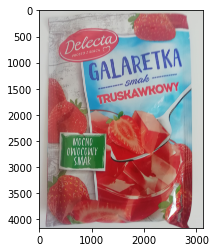

In [ ]:
from skimage import io
img_path = str(r'/content/drive/My Drive/projekt_DL/real/IMG_20200820_121238.jpg')
img = cv2.imread(img_path, 0)
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
plt.imshow(img)  # pokaż zdjęcie
img = cv2.resize(img, (224, 224))
test_image = image.img_to_array(img)
test_image = np.expand_dims(test_image, axis=0)
norm_image = test_image/255
test_pred = loaded_model.predict(norm_image)
pred = np.argmax(test_pred, axis=-1)
print(labels[pred[0]])

# 3 najlepsze wyniki - to jest nowość sprawdź czy działa
top_3 = np.argsort(test_pred[0])[:-4:-1]
print('\nTOP 3 wyniki:')
for i in range(3):
    print(f"{labels[top_3[i]]}: {test_pred[0][top_3[i]]}")